<a href="https://colab.research.google.com/github/jbwar/GPX_Heatmap/blob/main/Build_Strava_style_Heatmaps_from_GPX_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Strava style Heatmaps from GPX Data

In this project I will show you how to build Strava heatmaps with GPX data.

Strava's heatmaps are great for getting a bird's-eye view of your geo-spatial run data. But Strava hides their heatmaps behind their subscription service even for paid subscribers, they do not allow embedding or sharing of their heatmaps. This can be frustrating for average users who simply want to view and share interactive visualizations of data produced by their own effort and sweat!

What we are going to use:

1.   GPX data - I will show you how to download gpx data from Garmin Connect and provide a sample file, but you can use any gpx file.
2.   Python
3.   BigQuery
4.   Google Data Studio

All of the services we will be utilizing are available at no cost.
That's right, we are going to recreate a paid Strava service for F-R-E-E!

---


I am going to download gpx data from a run I did in Colorado in 2021. I use a Garmin fitness tracker, which connects to Garmin Connect. Whatever tracker and app you use should be very similar to this example. I am using this route because I do not live in Colorado and am not concerned about privacy in this instance. However you should always be cautious about what information you share or make public.


After logging in to Garmin Connect navigate the following:

Side menu > Activities > All Activities > Select the activity you wish to use

In the top right corner is the gear icon. Click it and you will get a pop up menu. Click Export to GPX and give the file a nice name.

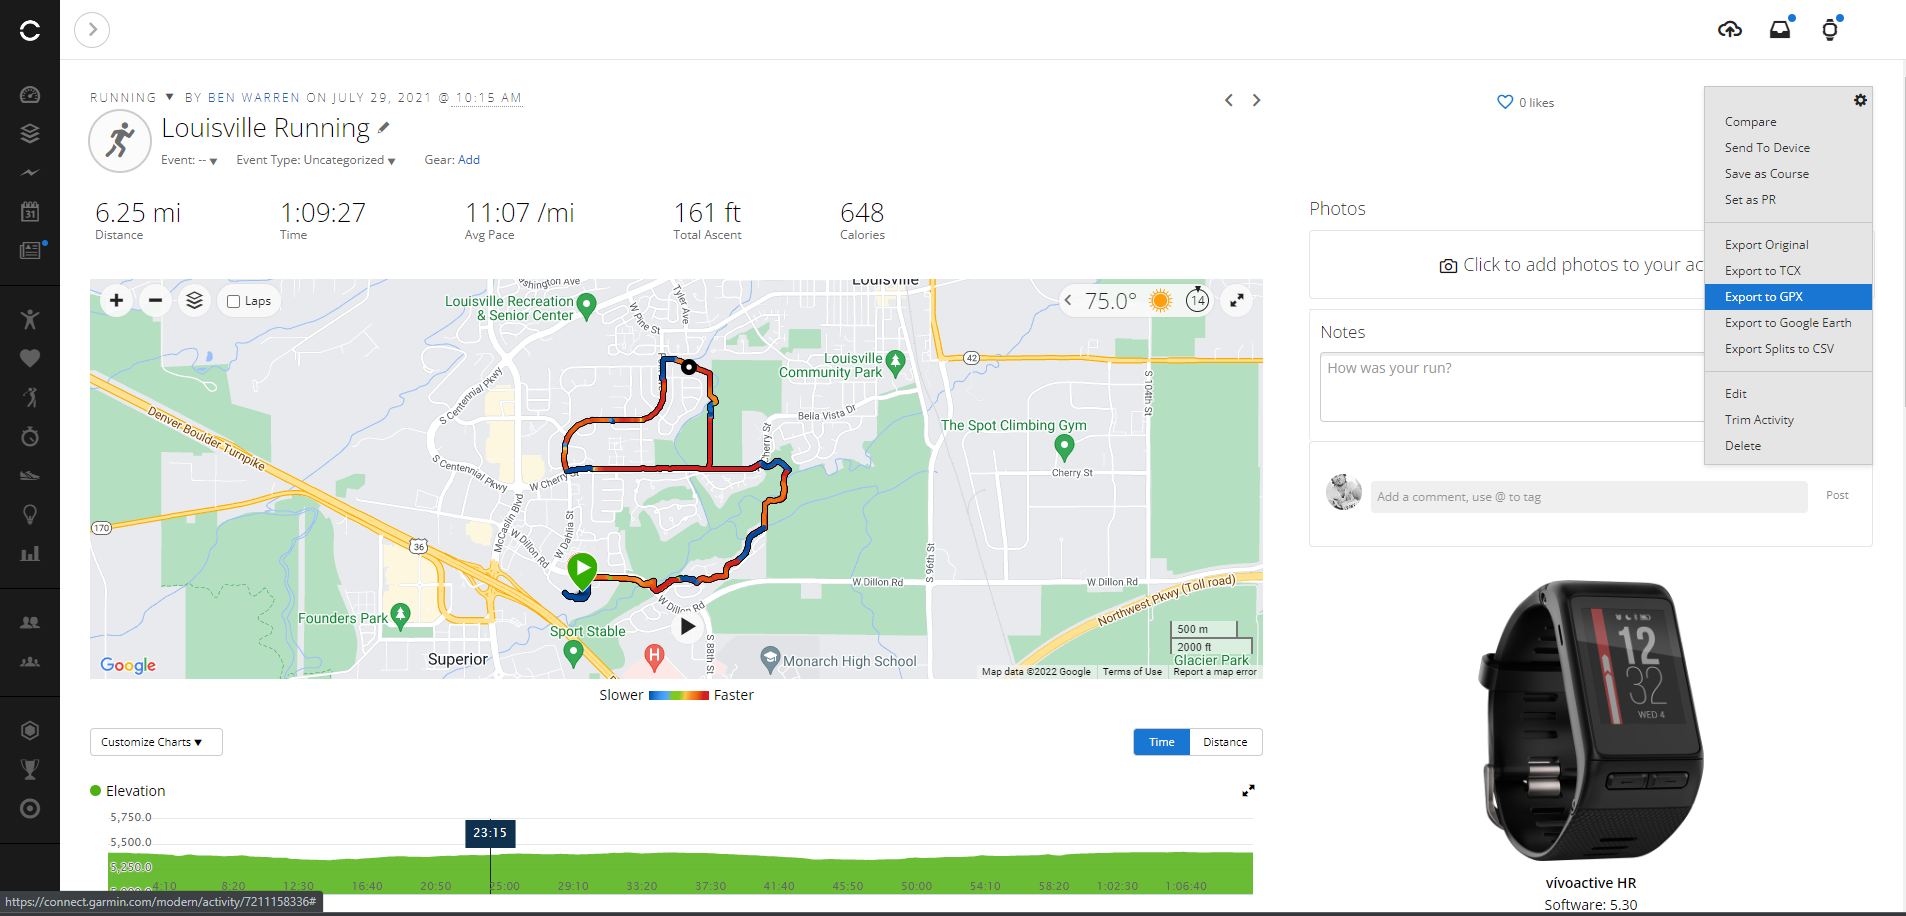

---



# Parsing and Cleaning the GPX Data

Because this is a single file we could convert it to a CSV using [gpsvisualizer](https://www.gpsvisualizer.com/) or a similar service and then do the cleaning in a spreadsheet. I'll include the necessary steps for that at the very end of this tutorial.

But if you're going to do multiple files -- e.g. a marathon training schedule to visualize multiple routes or routes in multiple locations -- it makes more sense to have a script that can parse and clean all those files with just a few clicks. 

Let's write a simple python script that we can run each time we downlaod some new gpx data and save ourselves some spreadsheet work.

In [ ]:
# Import libraries

import gpxpy
import gpxpy.gpx
import pandas as pd
import pytz
from pytz import all_timezones


In [ ]:
# Load gpx file by date
# Adding r before the file path converts the normal string to a raw string. File will not open otherwise.

with open(r#'yourfilepath\yourfilename.gpx', 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

In [ ]:
gpx

In [ ]:
# View gpx data points - lat, long, elev, datetime

gpx.tracks[0].segments[0].points[:10]

In [ ]:
route_info = []

for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                'latitude': point.latitude,
                'longitude': point.longitude,
                'altitude (m)': point.elevation,
                'datetime': point.time
            })
            
# I'm parsing date and time so I can split date and time into separate columns in a dataframe prior to uploading to BigQuery.
# This will allow me to filter the heatmap in Data Studio by date.

In [ ]:
# Verify data is parsed correctly

route_info[:1]

In [ ]:
# Convert array to pandas dataframe

route_df = pd.DataFrame(route_info)
route_df.head()

# For this example route, the datetime column timezone is UTC, and the route was recorded in US/Mountain.

In [ ]:
# Check timezone of datetime column

route_df['datetime']

In [ ]:
# Convert from UTC to US/Central
# I convert this to US/Central because it is the timezone I am currently in. You can convert it to any timezone.

route_df['datetime'] = route_df['datetime'].dt.tz_convert('US/Central')

route_df['datetime']

In [ ]:
# Split datetime into two columns - date and time

route_df['date'] = pd.to_datetime(route_df['datetime']).dt.date
route_df['time'] = pd.to_datetime(route_df['datetime']).dt.time

# View df

route_df

In [ ]:
# Reorder columns so indexing by date, time is cleaner

route_df = route_df[['date', 'time', 'latitude', 'longitude', 'altitude (m)']]
route_df

In [ ]:
# Export as CSV

route_df.to_csv(r#'yourfilepath\yourfilename.csv', index=False)

---



# Upload CSV to BigQuery

[BigQuery](https://cloud.google.com/bigquery) is part of the Google Cloud Platform data warehouse. Google Cloud does have a subscription tier service but many services are available in the free tier as long as you are under the montly usage limits. BigQuery is one of the services available in the free tier. It allows you to create and upload tabular data and query it with SQL.

I am not going to walk you through the sign-up process as it is very straightforward. You do have to put a card on file to prove you're human; but Google assures you your card **won't** be automatically charged even if you use all of the 90 day or $300 usage allowance in the free trial. Again, with this project we will be utilizing the free tier services and won't have to worry about any of that but it is good to remain aware of.

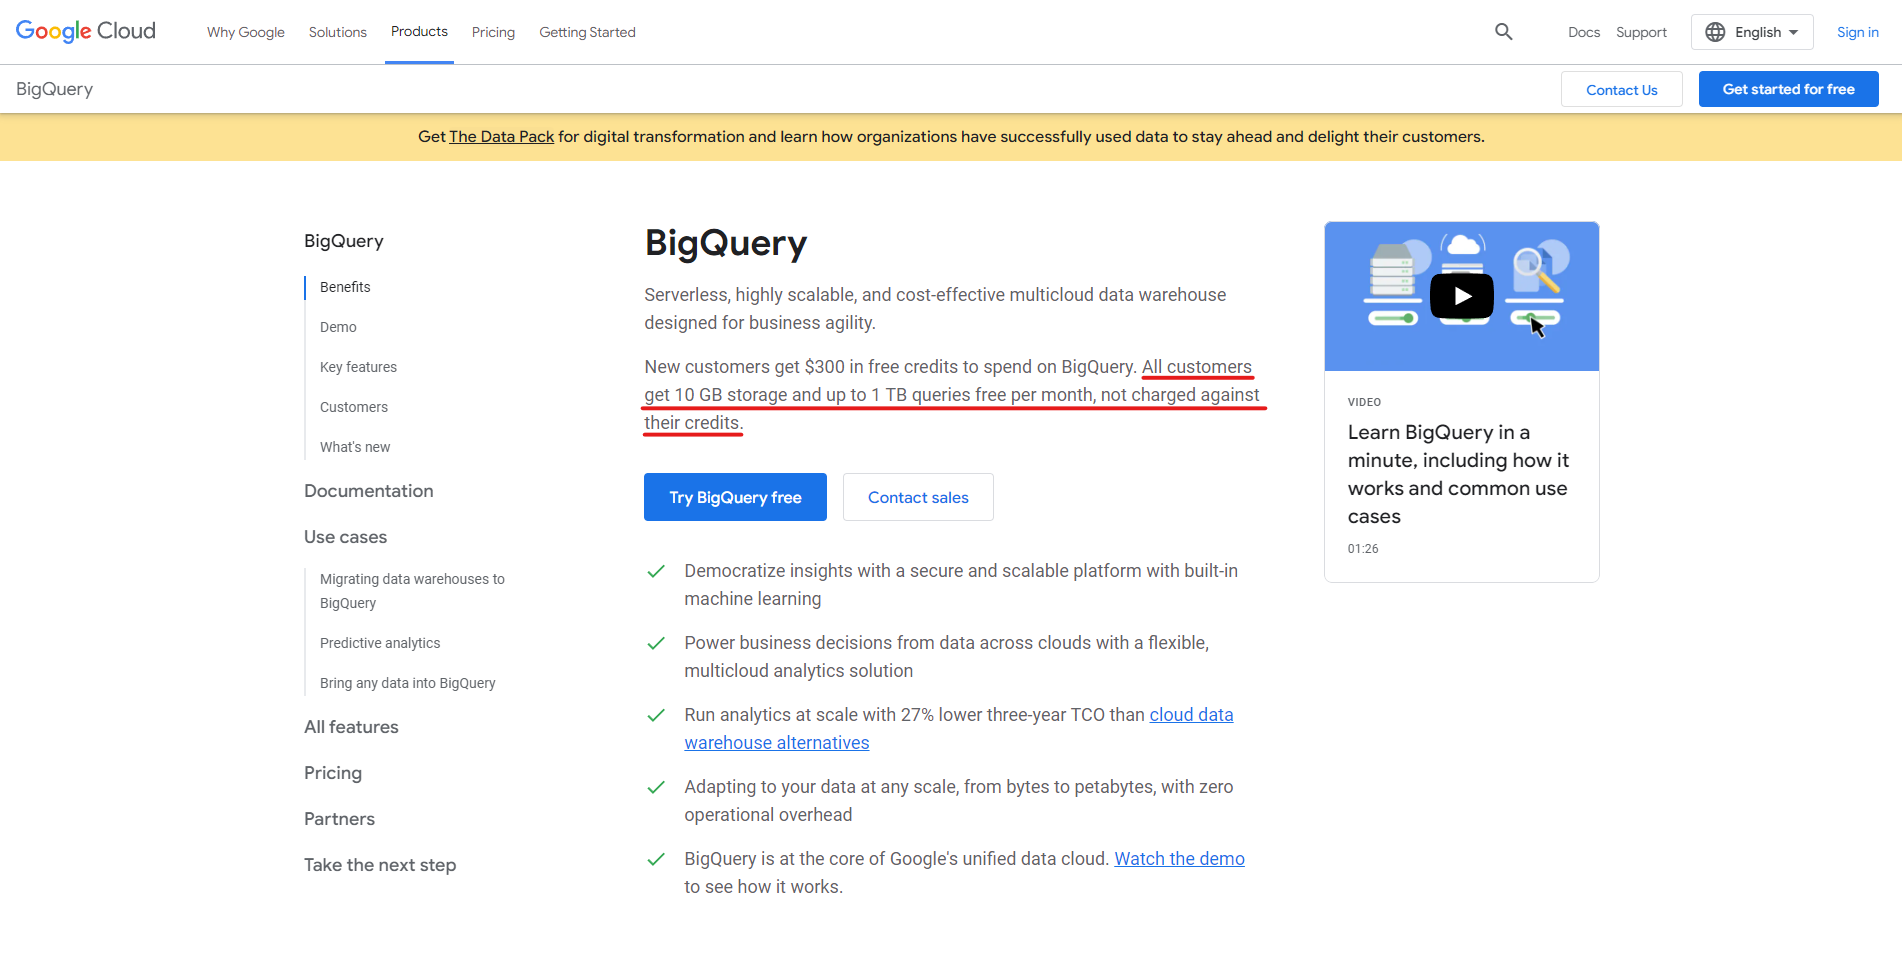

---



**1. On the left side menu, select BigQuery.**

**2. At the top left, next to Google Cloud, select the menu. When it opens click New Project.**

**3. Name your project and click Create. I named this one Heatmap.**

**4. Select the top menu next to Google Cloud again. When it opens select the project you just created.**


**5. In the Explorer pane you should see the name of your project. Click the 3 dots and click Create Dataset****

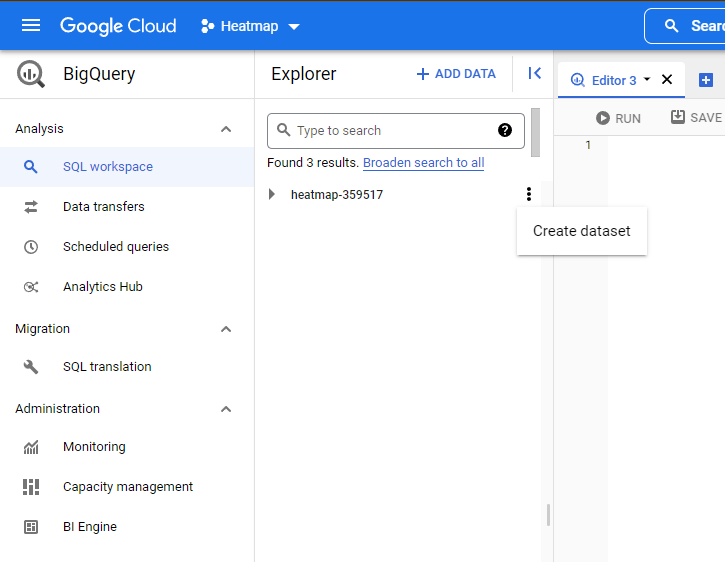

---



**6. A pane will open up. Enter whatever you like in the following fields. Fields I left blank can be left blank. Click Create Dataset.**

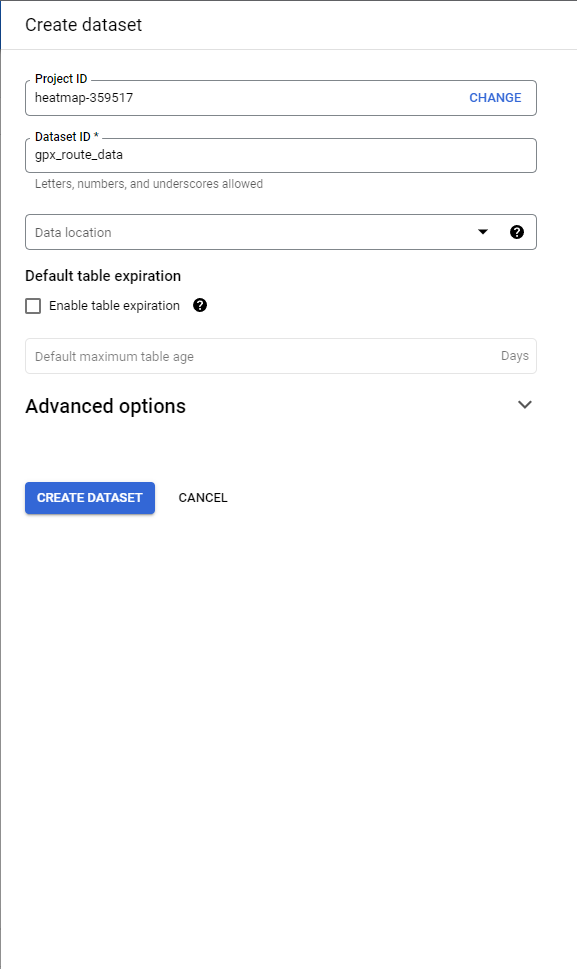

---



**7. The blank dataset should now appear under the project. You may need to click the triangle next to the project name to view it. If you see Saved Queries you can ignore this for now.**

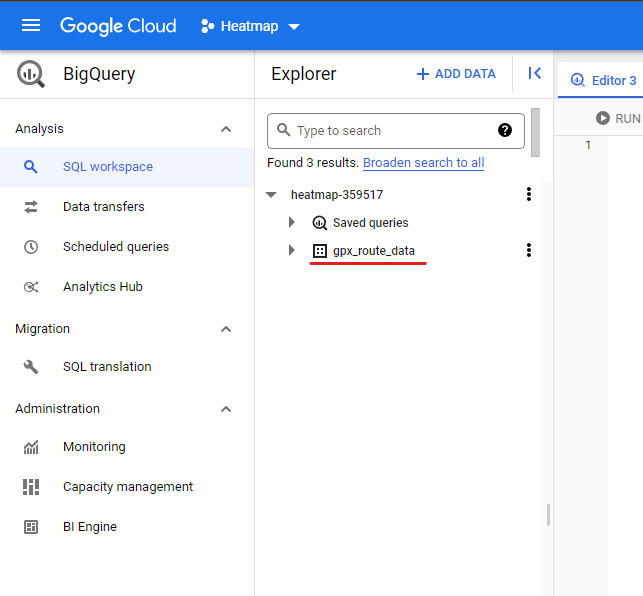

---



**8. Click the 3 dots next to the dataset we just made and click Create table.**

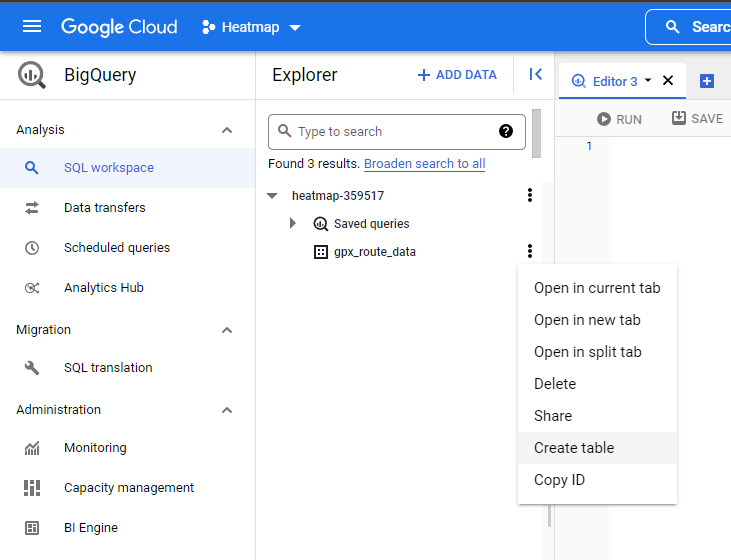

---



**9. We are uploading the csv file we got from our python script. You can name the table whatever you like. I kept it the same as the dataset. I set schema to auto detect. We don't need to change any advanced options here, and you can click Create Table. However, if you wish you upload multiple csv files to a single dataset in the future, in Advanced Options you would need to change the write preference to 'append to table' when you upload each subsequent csv file. The default is set to 'write if empty'.**

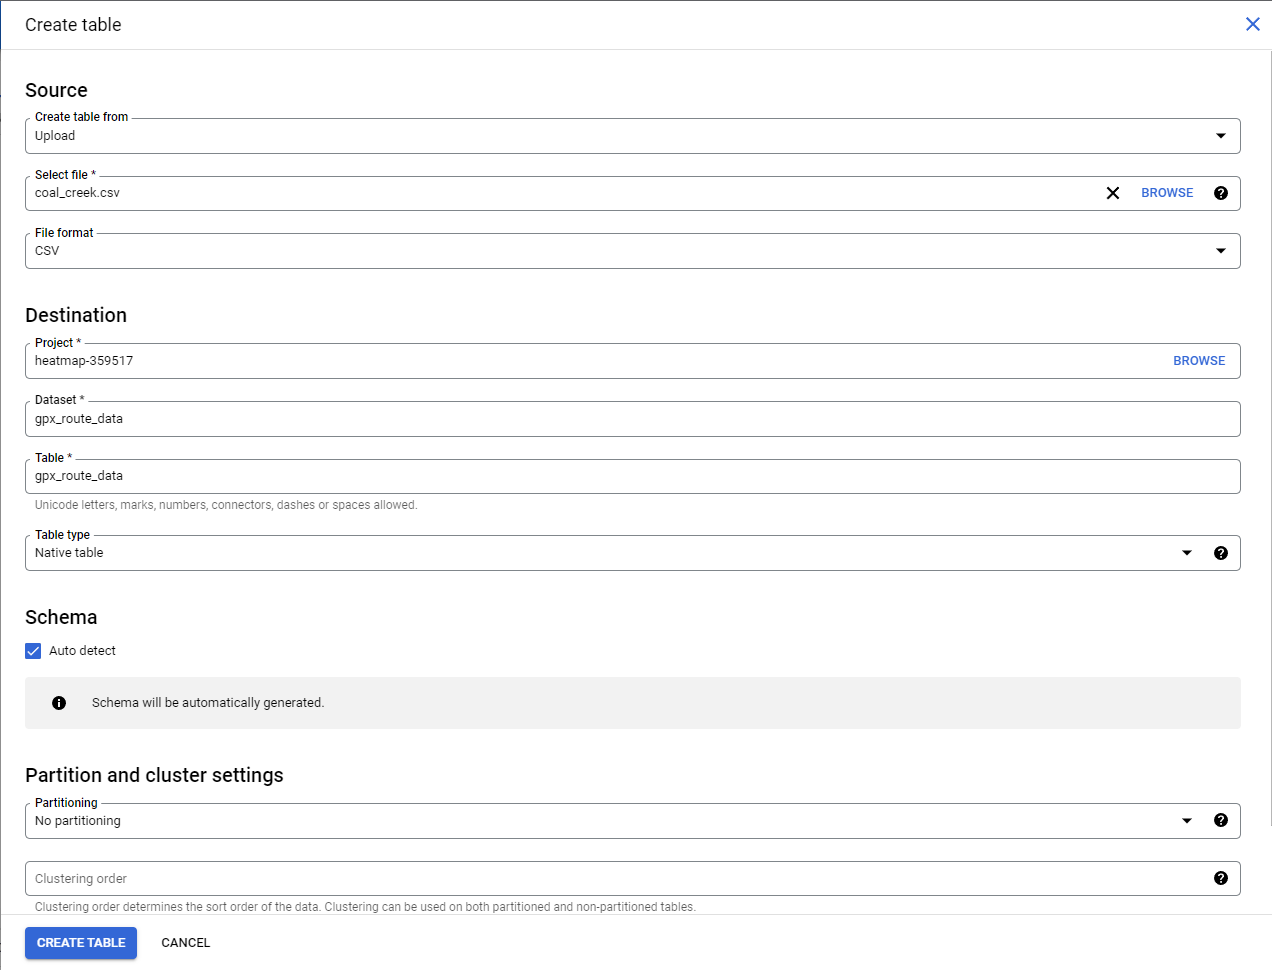

---



**10. We can now click on the table in the Explorer panel and view the Schema, Details, and Preview in the main panel.**

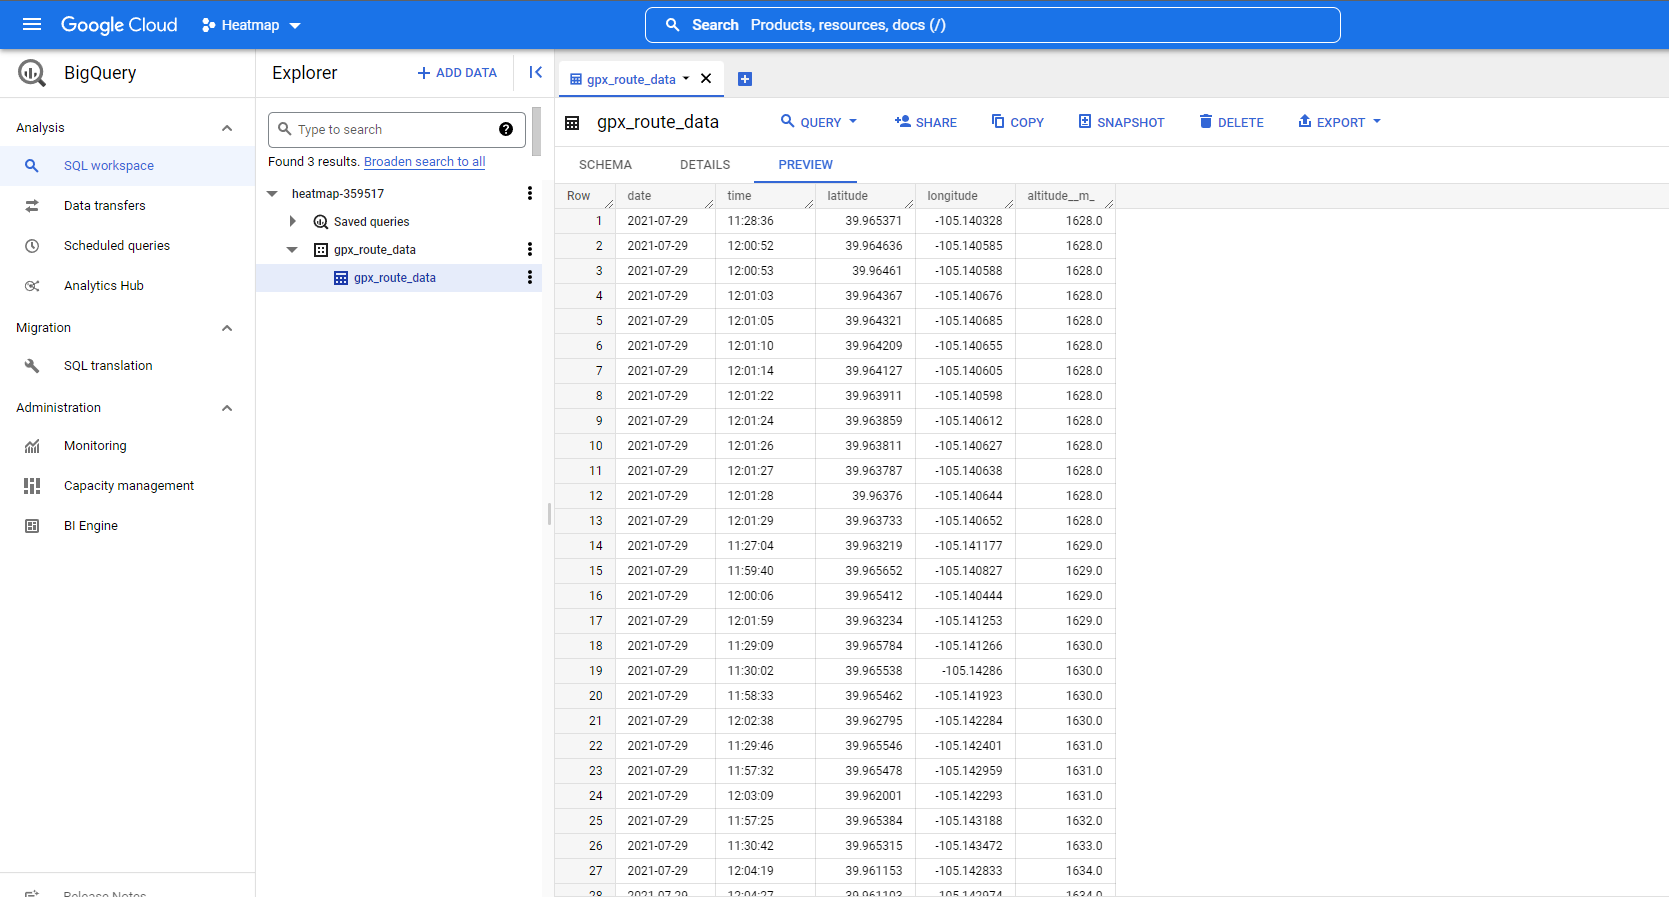




**That's it for this step. Next up - Connecting this table in BigQuery to Google Data Studio!**

---



# Connecting BigQuery to Google Data Studio

[Google Data Studio](https://datastudio.google.com/) is a suite of data visualization tools similar to Tableau. It is very easy to connect various data sources to Data Studio and the layout is very clean and user friendly.

**1. Click the Create button then click Data Source**

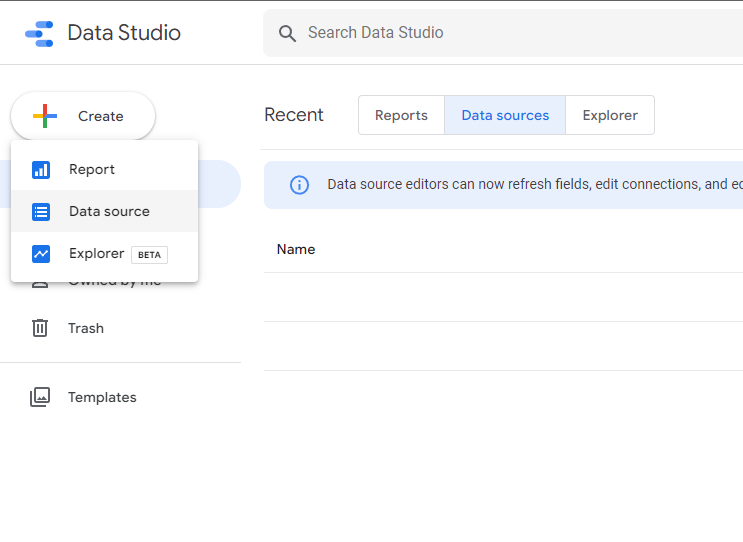

**2. Find and select BigQuery, you can use the search bar if needed.**

**3. Click your project >> the dataset >> the table you created.  Click Connect in the top right.**

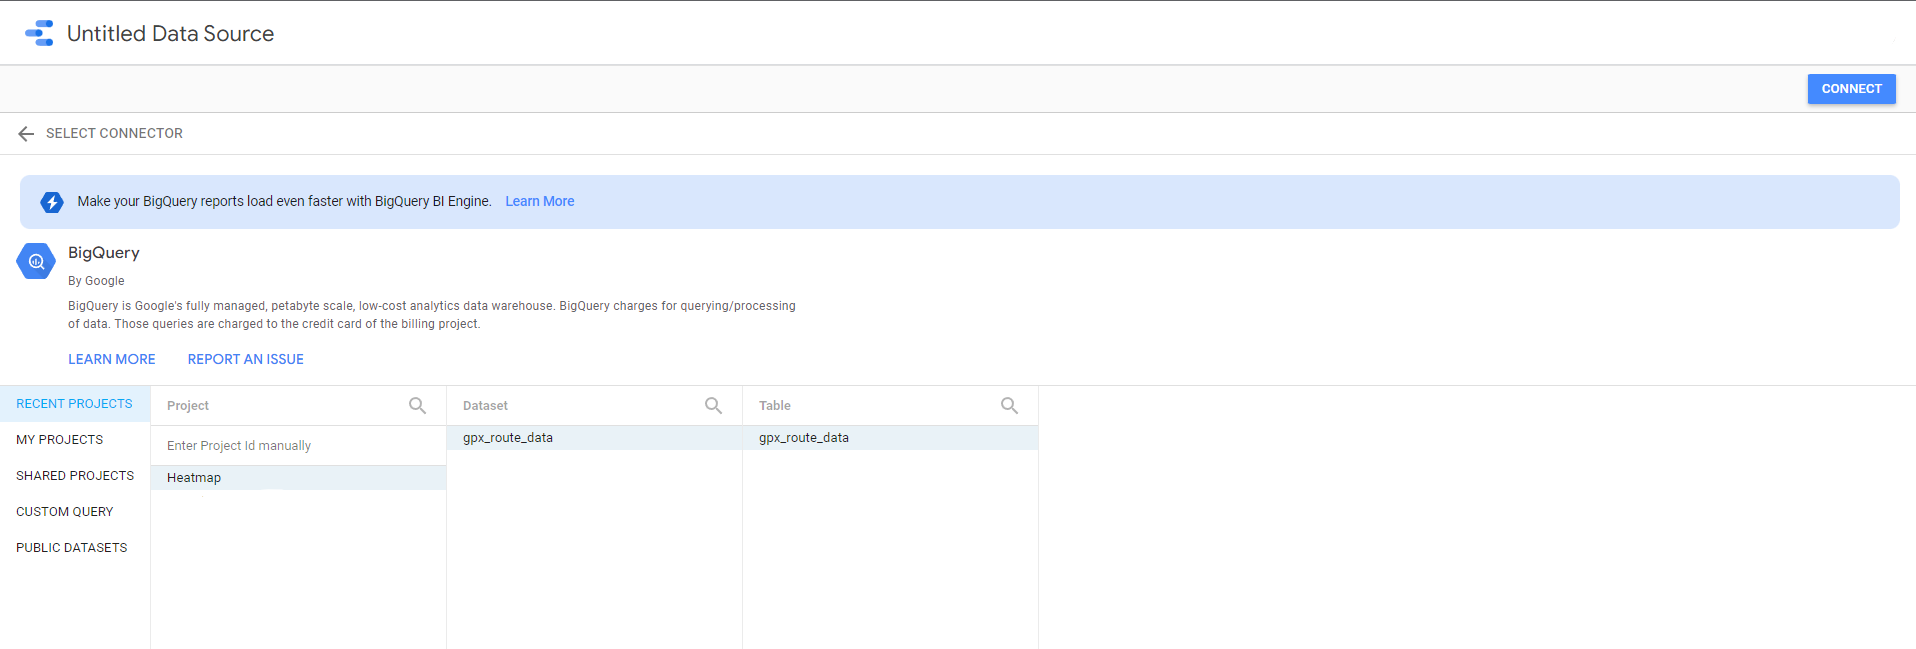

---



**You will be taken to the data source editor. Looking at the latitude and longitude columns, we can see the data type is numeric. We need to do 2 things before we can construct the heatmap.**

1. We need to create a new column that concatenates the latitude and longitude columns. We could have done this in the python script, but the Data Studio editor makes it as easy as editing a spreadsheet. Also if you decide you want to append new tables (new gpx files) to this existing table in BigQuery, the Data Studio source editor will automatically apply this step to the data source as it is updated -- i.e. this step basically automates it for all future data appended to this table.

2. We need to change the data type of the new field from numeric to Latitude, Longitude. The data source editor also makes step very simple. All you need to do is select the data type drop down menu under the Type field and select Geo >> Latitude, Longitude. Piece of cake!

**For Step 1 click '(+)Add A Field' near the top right. Name the field something like "Lat, Long". In the Formula field type the following function: CONCAT(latitude,", ",longitude) and click Update at the bottom right.**

Note* - you don't need to use the equal sign before CONCAT in the function as you would in a spreadsheet.

Near the top left is '<-- All Fields' which will take you back to the data source editor.

You should now be able to see the the Lat, Long field.

**For Step 2 change the datatype from 'Text' to 'Latitude, Longitude' as shown below.**

You will be asked to confirm the change.

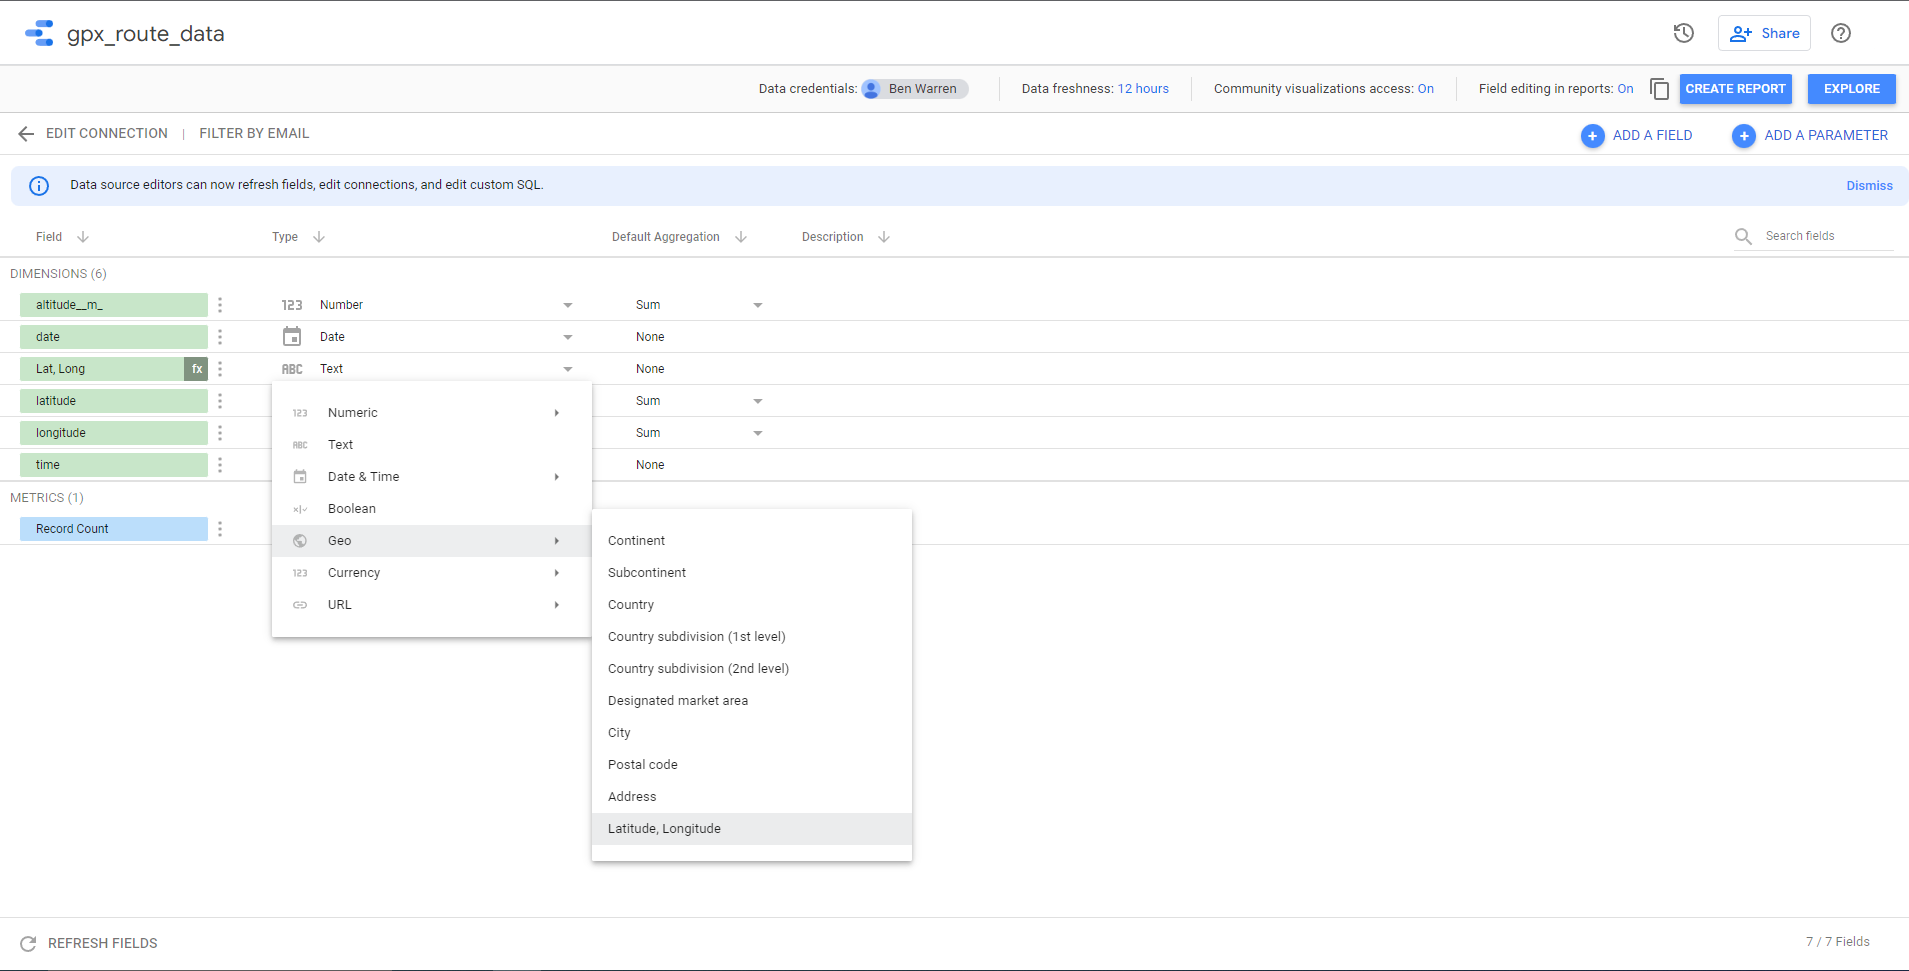


---



# Building the Heatmap

Now we have our data parsed, cleaned, uploaded, connected, and ready to be turned into a fully functional heatmap!

In the top right click Explore. This will take us to the chart editor. Clicking Report will take you to the report creator. For this project, we are simply going to build the visualization and don't need to create a report. You can decide how you wish to save and share it.





**In the Chart panel select Heatmap.**

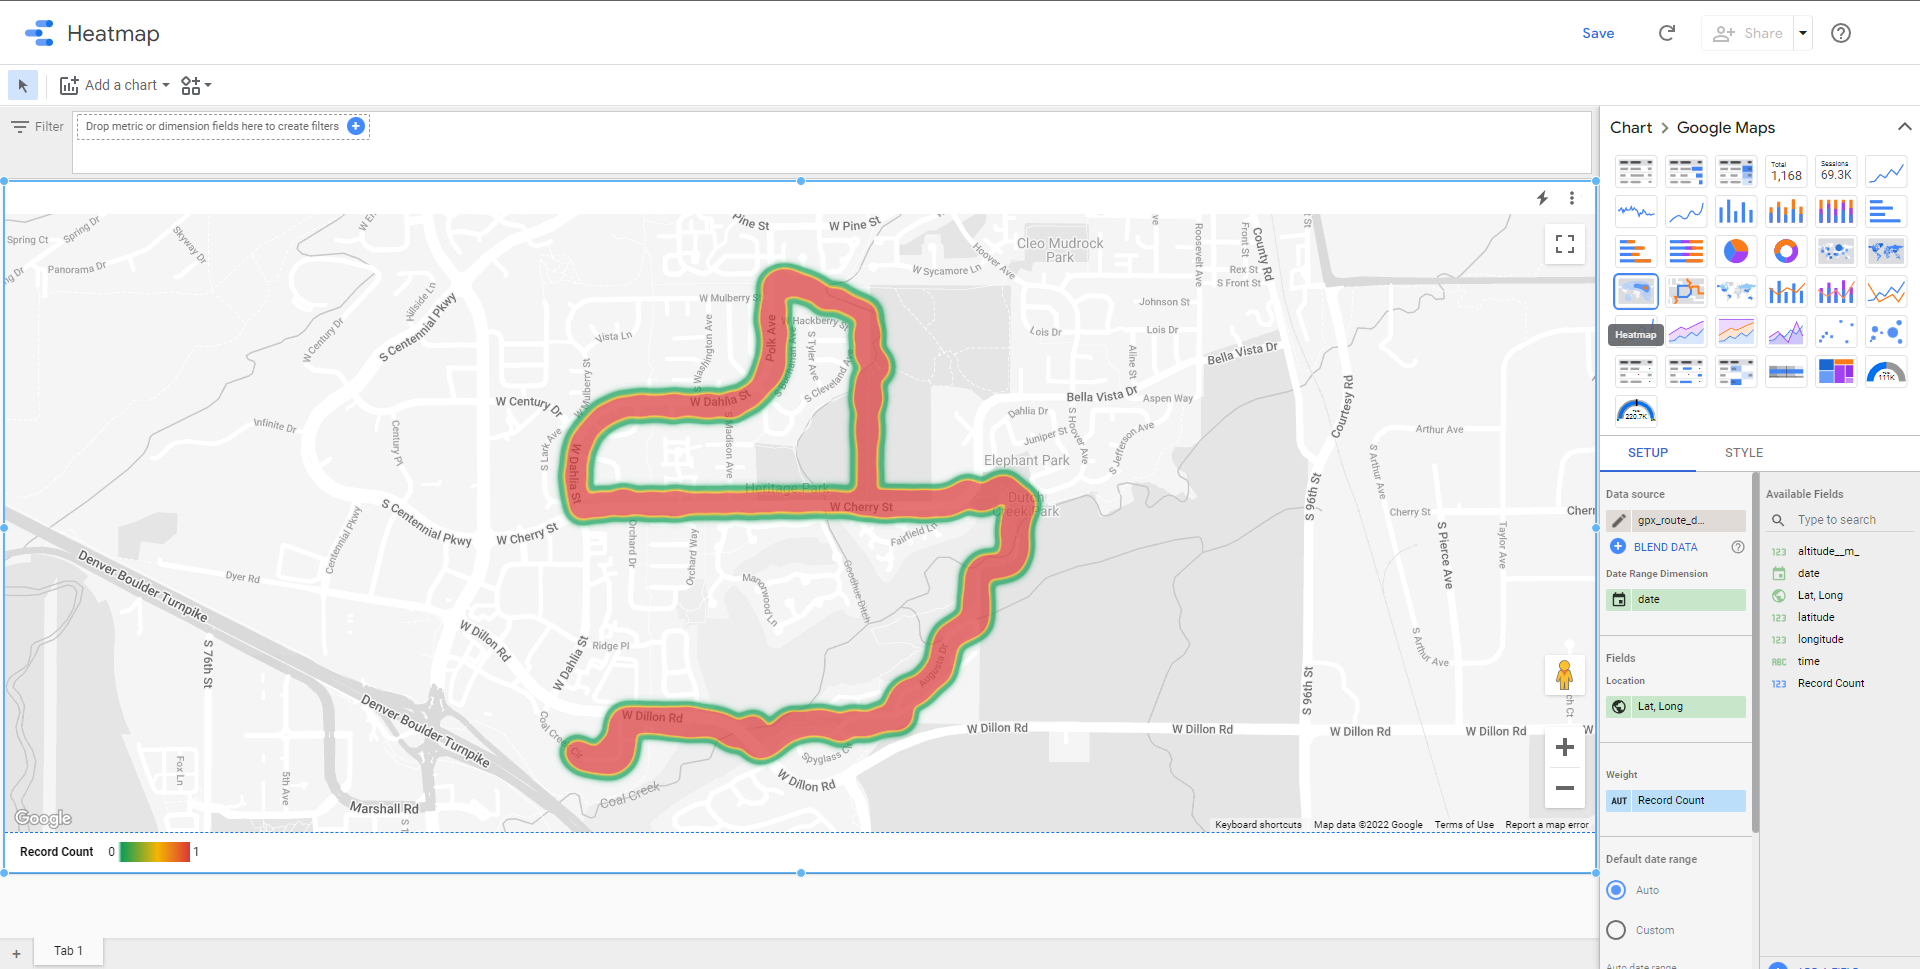

---



The Data Studio editor should automatically recognize the Lat, Long field you created and show you the route.

In the Style menu, next to Setup you can tweak additional settings such as:

**Map/Satellite** - Select the default hybrid map or satellite view

**Heatmap intensity** - adjust color and intensity of the highlighted route(s)

**Colors** - Change the heatmap colors

**Color domain min/max** - How intense the colors are depending on how many times you've completed the route.

For example:

Here I changed the colors to light blue for the minimum, purple for the median, and deep red for the maximum.

I set the domain minimum to 5 and the domain maximum to 50, and set intensity to the lowest.

If I were to run this route 50 times, the heatmap would change from light blue to purple to deep red. (As long as I continue to update the BigQuery dataset with the new route data.)

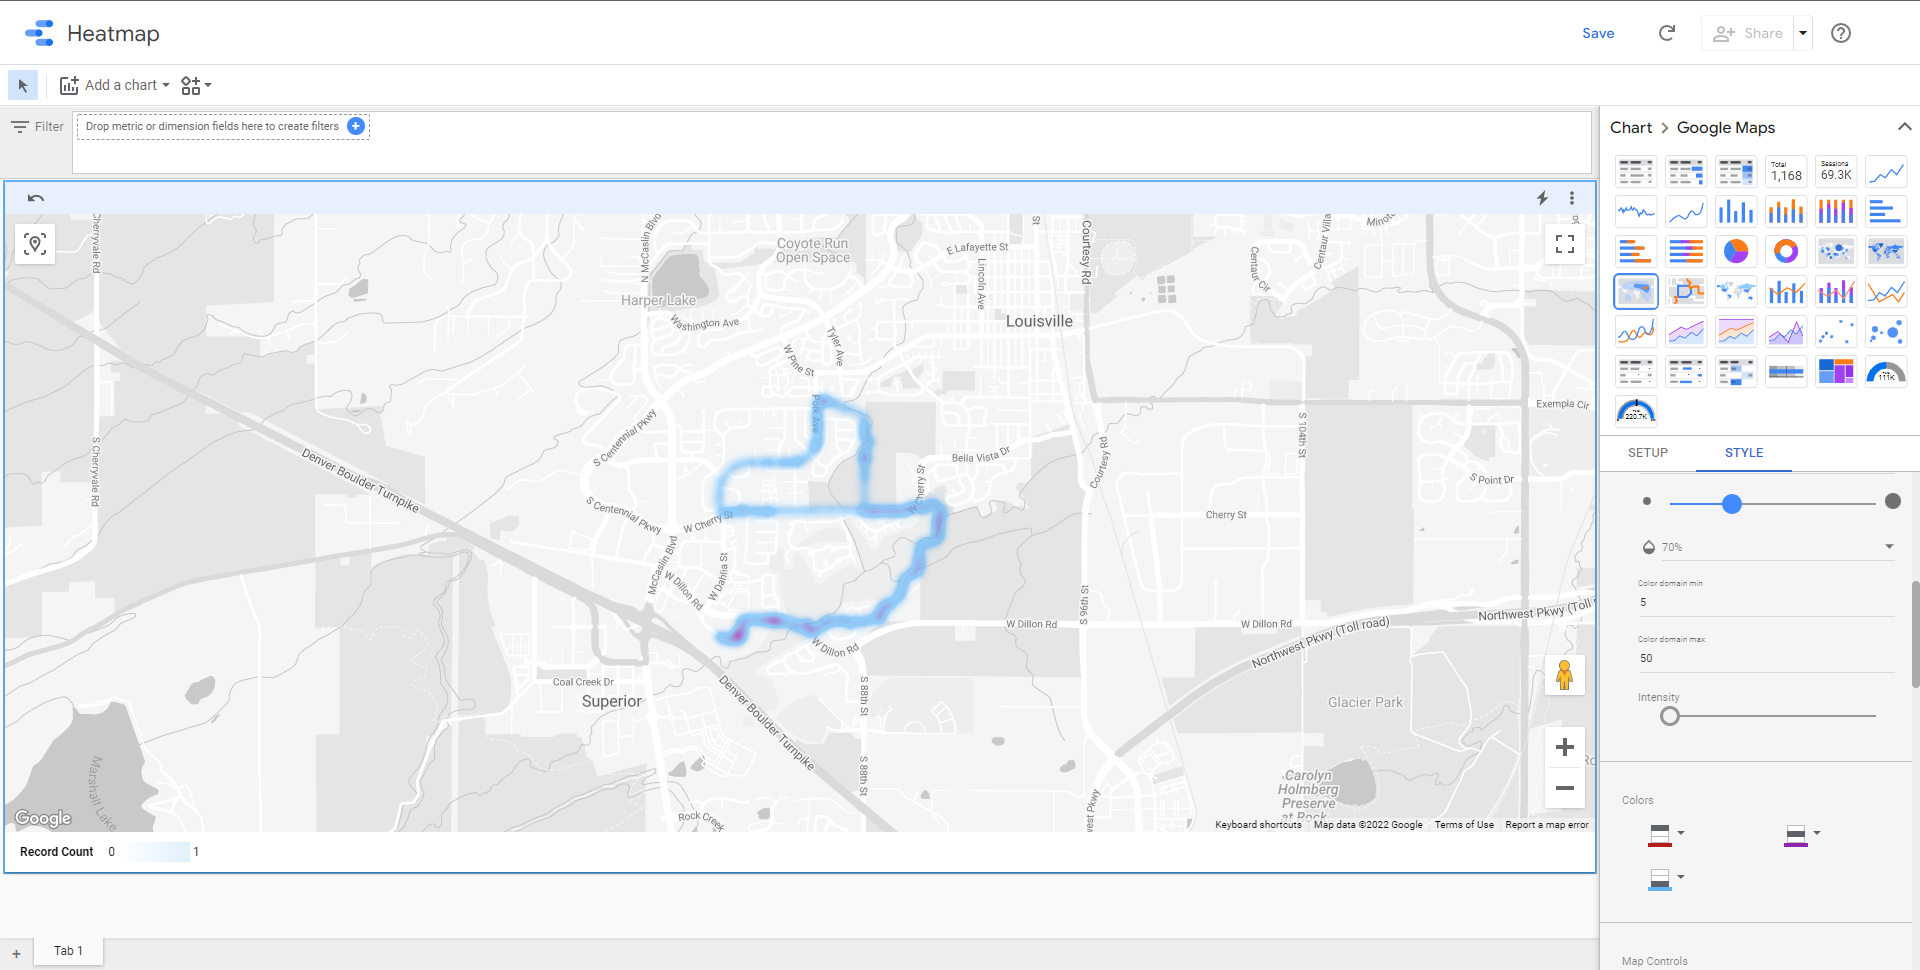

Congrats, You can now build Strava style heatmaps that are far more personal and customizable!

Let's recap what you accomplished --


Downloaded your GPX data.

Imported, cleaned, and converted it to tabular data.

Uploaded that .csv file to BigQuery to create a dataset.

Connected that dataset to Data Studio

Built a customizable heatmap of your GPX data.

---

Final notes:

If you upload routes from multiple days, you can create filters in the Report editor to filter your heatmap by day/distance/etc. This is nice because by default you can view the aggregate heatmap of all your routes, or select individual dates.

If you don't want to use python for the parsing and cleaning stage, you can use [gpsvisualizer](https://www.gpsvisualizer.com/) to convert a gpx file to a .txt table, import that to sheets or excel, clean the data, and export it to .csv.

1. Import the .txt file to Sheets or Excel
2. Split the datetime column into two separate columns 'date' and 'time'. There are many ways to do this. =LEFT(cell#, 10) will extract the date. =RIGHT(cell#, 8) will extract the time. E.g. =LEFT(A2, 10).
3. Copy just the values (not the formula) to the new respective columns. Ensure that you change the format of the date to YYYY-MM-DD, and time to HH:MM:SS. 
4. Time will likely be in UTC timezone, so if you want to conver to local -- CST for example -- you can use a cell# of your new time column minus TIME(5,0,0) where 5 is the difference between UTC and CST. E.G. =J2-TIME(5,0,0)
5. Delete all values in the fields you used to do the calculations and cleaning.
6. Export as .csv